**Human-in-the-loop**

In [ ]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote


In [3]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

import os

In [ ]:
# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "langgraph_5"


from langchain_teddynote.tools.tavily import TavilySearch
import os

# Set the Tavily API key as an environment variable
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [5]:
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

In [6]:
########## 6. interrupt_before 추가 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)


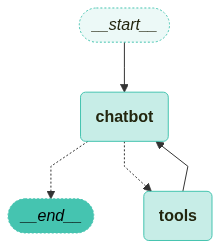

In [7]:
########## 7. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)


In [8]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")



[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_tvrub7IcwxoAsDChg24Is64Z)
 Call ID: call_tvrub7IcwxoAsDChg24Is64Z
  Args:
    query: AI


In [9]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next


('tools',)

In [10]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)


    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_tvrub7IcwxoAsDChg24Is64Z"
        type: "tool_call"


In [11]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_tvrub7IcwxoAsDChg24Is64Z)
 Call ID: call_tvrub7IcwxoAsDChg24Is64Z
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE1vT3NVaDQwbVI1S2ZZdXJhZWdrUWs0dDZtREhTMTJub01ISFAwYlNJSC1vTXM3c3N1WHp2VEVsRms4aFF2YXJ3bFF2U0tLaHZZYVNacWp3?oc=5", "content": "AI는 인간 통제 안에 있는 '도구'일까 - 지디넷코리아"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9wVVVoQ2o0clEzZHJVNnlwNTJDbXNTSE90ekpjaDNtcERrNmxiSG1UMVdkSU1TamI0bEpTNEQ0cWZhenA0M0NodXNlSEpNQzVWZEdQTU5iRFhSeVR5TFhhQ1BxakFsMEJyMFE?oc=5", "content": "애플, 이번에는 로봇공학 수석 AI 연구원 추가 이탈 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTFBjY2ZzN2VaS2tlN2NmNjJBV2NrN0hDd1pTVXlrUTNqTXJzQUNzeVRZMlVNWUxCZHdta1pGamxsU0x0elBSSFBXd0Yyd2ZmZw?oc=5", "content": "[IFA 2025]삼성전자, 현실이 된 '미래 AI 홈' 구현 - 전자신문

In [12]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state


메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


In [13]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)


('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f089611-144c-6bc6-8002-7f44f8bd4be6'}}


In [14]:
to_replay.config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f089611-144c-6bc6-8002-7f44f8bd4be6'}}

In [18]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()


================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE1vT3NVaDQwbVI1S2ZZdXJhZWdrUWs0dDZtREhTMTJub01ISFAwYlNJSC1vTXM3c3N1WHp2VEVsRms4aFF2YXJ3bFF2U0tLaHZZYVNacWp3?oc=5", "content": "AI는 인간 통제 안에 있는 '도구'일까 - 지디넷코리아"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE9wVVVoQ2o0clEzZHJVNnlwNTJDbXNTSE90ekpjaDNtcERrNmxiSG1UMVdkSU1TamI0bEpTNEQ0cWZhenA0M0NodXNlSEpNQzVWZEdQTU5iRFhSeVR5TFhhQ1BxakFsMEJyMFE?oc=5", "content": "애플, 이번에는 로봇공학 수석 AI 연구원 추가 이탈 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTFBjY2ZzN2VaS2tlN2NmNjJBV2NrN0hDd1pTVXlrUTNqTXJzQUNzeVRZMlVNWUxCZHdta1pGamxsU0x0elBSSFBXd0Yyd2ZmZw?oc=5", "content": "[IFA 2025]삼성전자, 현실이 된 '미래 AI 홈' 구현 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxPLXoybVlweWlHN3M0QUpCZFgtc0lHM2VxN1UxaGphS3NYdi1ReDdSUkxxNGVfRWxGV2xvb1FOZlJTY1hmZFVQeTNWTmVNZ2cwV3ktSllnUDMyczVfaHNsTkVwNy1mWHFOSmpkY083b3